# Modelisation CamenBERT

## Librairies et fichiers

In [1]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1_2JJeYhhAHn4xWGD5kC2VtjM-_SxznEm/nov23_bds_rakuten


Import des librairies

In [2]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers import CamembertTokenizer, CamembertForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import torch
from torch.nn.functional import softmax
from torch.utils.data import DataLoader

#from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

output_path = "output/data-modeling-text-6-CamenBERT/"

In [4]:
# Catégories pour visu matrice
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech.",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant, déguisement",
    1281 : "Jeu de société",
    1300 : "Jouet tech",
    1301 : "Paire de chaussettes",
    1302 : "Jeu extérieur, vêtement",
    1320 : "Autour du bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues et journaux",
    2403 : "Magazines, livres et BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique et papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Autour de la piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

## Prétraitement des données et encodage des catégories

### **Choix du type de texte en entrée (avec ou sans sens)**

Fichier contenant le texte nettoyé, mais avec le contexte (le sens)

In [5]:
df_train = pd.read_csv('output/data-preprocessing-resampling/df_train.csv', index_col=0)
display(df_train.head(2))
df_val = pd.read_csv('output/data-preprocessing-resampling/df_val.csv', index_col=0)

,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,131641431,885888766,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,fr,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,10/image_885888766_product_131641431.jpg,10
1,745789761,1304710852,The Inglorious Arts Of Peace: Exhibitions In C...,en,Les arts de la paix sans gloire: expositions d...,10/image_1304710852_product_745789761.jpg,10


### Formattage

Il est essentiel de nettoyer les données textuelles, ce qui peut inclure la suppression de la ponctuation inutile, la conversion en minuscules, etc. Toutefois, comme nous utilisons CamemBERT, qui est entraîné sur des textes français dans leur forme naturelle, nous minimiserons le prétraitement pour conserver les spécificités du langage.

#### Encodage des catégories

Nous devons convertir les catégories en valeurs numériques. Cela peut être fait avec LabelEncoder de scikit-learn

In [6]:
# Encodage des catégories
label_encoder = LabelEncoder()
df_train['prdtypecode'] = label_encoder.fit_transform(df_train['prdtypecode'])
df_val['prdtypecode'] = label_encoder.transform(df_val['prdtypecode'])

# Séparation des données et des étiquettes
train_texts, train_labels = df_train['text_fr'].tolist(), df_train['prdtypecode'].tolist()
val_texts, val_labels = df_val['text_fr'].tolist(), df_val['prdtypecode'].tolist()

#### Tokenisation

In [7]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Conversion des données pour PyTorch

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

# **Création et entraînement du modèle**

Nous utiliserons la bibliothèque transformers pour charger le modèle CamemBERT pré-entraîné avec une tête de classification à la fin.

In [9]:
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=27)

training_args = TrainingArguments(
    output_dir = 'output/data-modeling-text-6-CamenBERT/results',
    num_train_epochs = 3,             # nombre total d'époques d'entraînement.
    per_device_train_batch_size = 8,  # Tailles des lots pour l'entraînement et l'évaluation, respectivement, par appareil (GPU/CPU)
    per_device_eval_batch_size = 8,
    warmup_steps = 500,               # Nombre de pas d'entraînement pendant lesquels l'apprentissage est progressivement accéléré, avant d'atteindre la vitesse d'apprentissage principale
    weight_decay = 0.01,              # Taux de déclin des poids pour la régularisation.
    logging_dir = 'output/data-modeling-text-6-CamenBERT/logs',
    logging_steps = 10,               # Configuration pour enregistrer les logs d'entraînement.
    evaluation_strategy = "epoch",    # Évaluer à la fin de chaque époque
    save_strategy = "epoch",          # Sauvegarder le modèle à la fin de chaque époque
    load_best_model_at_end = True,    # Charger le meilleur modèle à la fin de l'entraînement
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



**Passer au chargement du modèle si pas d'entrainement**







In [10]:

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.348400,0.540434,0.863636
2,0.255700,0.576121,0.876943
3,0.139200,0.614319,0.888719


TrainOutput(global_step=41088, training_loss=0.3884870169116585, metrics={'train_runtime': 10301.31, 'train_samples_per_second': 31.908, 'train_steps_per_second': 3.989, 'total_flos': 8.650349031564288e+16, 'train_loss': 0.3884870169116585, 'epoch': 3.0})

# **Enregistrement/Chargement du modèle**

In [11]:
model_path = output_path + "modele_camembert_025"

## Sauvegarde du modèle

In [12]:
# Enregistrer le modèle
model.save_pretrained(model_path)

# Enregistrer le tokenizer associé au modèle
tokenizer.save_pretrained(model_path)

('output/data-modeling-text-6-CamenBERT/modele_camembert_025/tokenizer_config.json',
 'output/data-modeling-text-6-CamenBERT/modele_camembert_025/special_tokens_map.json',
 'output/data-modeling-text-6-CamenBERT/modele_camembert_025/sentencepiece.bpe.model',
 'output/data-modeling-text-6-CamenBERT/modele_camembert_025/added_tokens.json')

## Chargement du modèle

In [13]:
# # Recharger le modèle
# model = CamembertForSequenceClassification.from_pretrained(model_path)

# # Recharger le tokenizer
# tokenizer = CamembertTokenizer.from_pretrained(model_path)

In [14]:
# # Créer un objet Trainer pour le modèle chargé
# trainer = Trainer(
#     model=model,
#     args=TrainingArguments(
#         output_dir='/tmp/results',  # Mettez à jour si nécessaire
#         per_device_eval_batch_size=8,
#     ),
#     compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
# )

# **Évaluation**

## **Préparation jeu de test**

In [15]:
df_test = pd.read_csv('output/data-preprocessing-resampling/df_test.csv', index_col=0)

In [16]:
df_test['prdtypecode'] = label_encoder.transform(df_test['prdtypecode'])

# Séparation des données et des étiquettes
test_texts, test_labels = df_test['text_fr'].tolist(), df_test['prdtypecode'].tolist()

test_encodings = tokenize_function(test_texts)
test_dataset = Dataset(test_encodings, test_labels)

In [17]:
predictions = trainer.predict(test_dataset)

Nous utiliserons les métriques pour évaluer les performances du modèle sur df_test.

In [18]:
y_pred = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(test_labels, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.865049458313707
Precision: 0.8689109828829197
Recall: 0.865049458313707
F1-Score: 0.8647765864267043


 inverse_transform pour obtenir les codes de catégories d'origine

In [19]:
# Pour les étiquettes de test originales
test_labels_original = label_encoder.inverse_transform(test_labels)

# Pour les étiquettes prédites
y_pred_original = label_encoder.inverse_transform(y_pred)

In [20]:
#y_test
y_test_visu = [prdcodetype2label.get(code, "Label") for code in test_labels_original]

# y_pred
y_pred_visu = [prdcodetype2label.get(code, "Label") for code in y_pred_original]

Score du modèle : 0.865049458313707


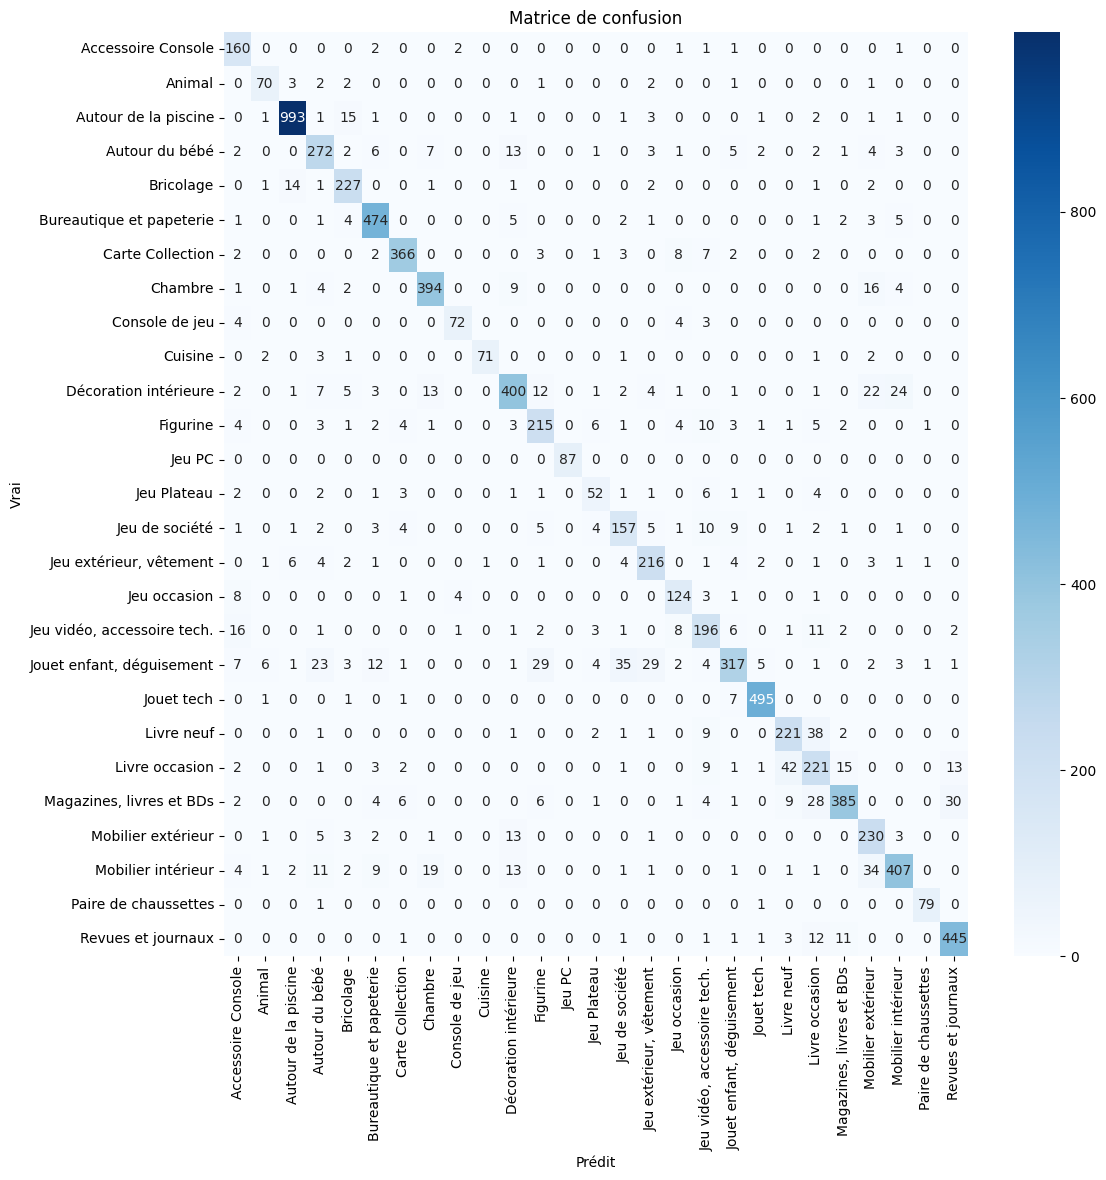

In [21]:

# Calculer le score du modèle
score = accuracy_score(y_test_visu, y_pred_visu)
print("Score du modèle :", score)

# Créer et afficher la matrice de confusion
mat_conf = pd.crosstab(y_test_visu, y_pred_visu)

plt.figure(figsize=(12, 12))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()

In [22]:
print(classification_report(y_test_visu, y_pred_visu))

                             precision    recall  f1-score   support

         Accessoire Console       0.73      0.95      0.83       168
                     Animal       0.83      0.85      0.84        82
       Autour de la piscine       0.97      0.97      0.97      1021
             Autour du bébé       0.79      0.84      0.81       324
                  Bricolage       0.84      0.91      0.87       250
   Bureautique et papeterie       0.90      0.95      0.93       499
           Carte Collection       0.94      0.92      0.93       396
                    Chambre       0.90      0.91      0.91       431
             Console de jeu       0.91      0.87      0.89        83
                    Cuisine       0.99      0.88      0.93        81
      Décoration intérieure       0.87      0.80      0.83       499
                   Figurine       0.78      0.81      0.79       267
                     Jeu PC       1.00      1.00      1.00        87
                Jeu Plateau      

# Fonctions

Préparer un DataFrame pour trainer.predict()

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

def prepare_dataset(df, tokenizer):
    # Tokenisation des textes de la colonne 'text_fr'
    encodings = tokenizer(df['text_fr'].tolist(), truncation=True, padding=True, max_length=512)
    # Création du dataset
    dataset = Dataset(encodings)
    return dataset


Obtenir les prédictions sous forme de probabilités

In [24]:
def get_predictions(trainer, dataset):
    # Obtenir les prédictions (logits)
    predictions_output = trainer.predict(dataset)
    predictions = predictions_output.predictions
    # Convertir les logits en probabilités
    probabilities = torch.softmax(torch.tensor(predictions), dim=1).numpy()
    return predictions, probabilities